# In this notebook, we would search for the similar clothings that matches the most with the attributes specified by the user using KNN algorithm

# Packages import

In [1]:
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import random
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack

# Data Import

In [2]:
os.chdir("D:\Projects\Flipkart")

In [3]:
from pprint import pprint

df = pd.read_json('dataset/Description/shirt.json')

print ('Number of data points : ', df.shape[0], \
       'Number of features/variables:', df.shape[1])

df

Number of data points :  345 Number of features/variables: 14


,Image,Brand,Size,Type,Color,Regional Existence,Gender,Body Type,Occasion,Price,Age,Style,Sleeves,Rating
0,Images/shirt/1.jpg,Nike,S,Shirt,Red,All over India,Unisex,Regular,Outdoor Activities,1413,above 30 years,Button-Down Shirt,Long sleeved,3.80
1,Images/shirt/10.jpg,Nike,L,Shirt,Blue,Tamil Nadu,Male,Regular,Casual,953,15-20 years,Dress Shirt,Long sleeved,4.60
2,Images/shirt/100.jpg,Peter England,S,Shirt,Green,Punjab,Unisex,Short,Outdoor Activities,1122,above 50 years,Plain Shirt,Sleeveless,3.96
3,Images/shirt/101.jpg,Nike,M,Shirt,Green,South India,Male,Regular,Cultural and Festive Celebrations,917,20-30 years,Plain Shirt,Long sleeved,4.42
4,Images/shirt/102.jpg,Express,M,Shirt,Yellow,North India,Male,Regular,Formal,1470,15-20 years,Plain Shirt,Sleeveless,3.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,Images/shirt/95.jpg,Arrow,S,Shirt,White,All over India,Female,Tall,Business-Casual,1561,15-20 years,Polo Shirt,Sleeveless,2.59
341,Images/shirt/96.jpg,Lyra,XXL,Shirt,Yellow,North India,Male,Athletic/Muscular,Outdoor Activities,1066,less than 15 years,Polo Shirt,Sleeveless,2.33
342,Images/shirt/97.jpg,Lyra,XXL,Shirt,Pink,Kerala and Tamil Nadu,Male,Tall,Outdoor Activities,911,above 30 years,Polo Shirt,Long sleeved,3.87
343,Images/shirt/98.jpg,Zara,M,Shirt,Red,Gujarat and Rajasthan,Unisex,Athletic/Muscular,Cultural and Festive Celebrations,1634,above 30 years,Check Shirt,Sleeveless,3.27


# Data pre-processing

### Deleting entries having no image details

In [4]:
df = df.loc[~df['Price'].isnull()]
print('Number of data points before eliminating price=NULL :', df.shape[0])

df =df.loc[~df['Color'].isnull()]
print('Number of data points After eliminating color=NULL :', df.shape[0])

Number of data points before eliminating price=NULL : 345
Number of data points After eliminating color=NULL : 345


### Assigning mod for NULL values for categorical features: Brand, Regional Existence, Body Type

In [5]:
# Calculate the mode of the entire DataFrame
mode_values = df.mode().iloc[0]

# Columns to replace NULL values
columns_to_replace = ['Brand', 'Regional Existence', 'Body Type']

# Replace NULL values with the mode values
for column in columns_to_replace:
    df[column] = df[column].fillna(mode_values[column])

### Replacing NULL values of 'Rating' column with average of that column

In [6]:
average_rating = df['Rating'].mean()

# Replace NULL values in the 'Rating' column with the average value
df['Rating'].fillna(average_rating, inplace=True)

# KNN Algo

In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

In [42]:
# User input for attributes (replace with user input)
user_input ={
    "Brand": "Nike",
    "Size": "M",
    "Type": "Shirt",
    "Color": "White",
    "Regional Existence": "Tamil Nadu",
    "Gender": "Male",
    "Body Type": "Athletic/Muscular",
    "Occasion": "Outdoor Activities",
    "Price": 900,
    "Age": "less than 15 years",
    "Style": "Plain Shirt",
    "Sleeves": "Sleeveless",
    "Rating": 5
}

In [43]:
# Convert user input to DataFrame
user_df = pd.DataFrame(user_input, index=[0])
user_df

,Brand,Size,Type,Color,Regional Existence,Gender,Body Type,Occasion,Price,Age,Style,Sleeves,Rating
0,Nike,M,Shirt,Red,Tamil Nadu,Male,Athletic/Muscular,Outdoor Activities,900,less than 15 years,Plain Shirt,Sleeveless,5


In [44]:
selected_columns = ['Brand', 'Size', 'Type', 'Color', 'Regional Existence','Gender', 'Body Type', 'Occasion', 'Price', 'Age', 'Style', 'Sleeves', 'Rating']
df_knn = df[selected_columns]
df_knn.head(1)

,Brand,Size,Type,Color,Regional Existence,Gender,Body Type,Occasion,Price,Age,Style,Sleeves,Rating
0,Nike,S,Shirt,Red,All over India,Unisex,Regular,Outdoor Activities,1413,above 30 years,Button-Down Shirt,Long sleeved,3.8


In [45]:
# Encode categorical columns and normalize numerical columns
categorical_columns = ['Brand', 'Type', 'Size', 'Color', 'Regional Existence', 'Gender', 'Body Type', 'Occasion', 'Age', 'Style', 'Sleeves']
numerical_columns = ['Price', 'Rating']

In [46]:
scaler = MinMaxScaler()
df_knn_encoded = pd.get_dummies(df_knn, columns=categorical_columns)
df_knn_encoded[numerical_columns] = scaler.fit_transform(df_knn_encoded[numerical_columns])
df_knn_encoded.head(1)

,Price,Rating,Brand_Adidas,Brand_Arrow,Brand_Calvin Klein,Brand_Express,Brand_Levi's,Brand_Lyra,Brand_Nike,Brand_Peter England,...,Age_above 30 years,Age_above 50 years,Age_less than 15 years,Style_Button-Down Shirt,Style_Check Shirt,Style_Dress Shirt,Style_Plain Shirt,Style_Polo Shirt,Sleeves_Long sleeved,Sleeves_Sleeveless
0,0.815653,0.610169,False,False,False,False,False,False,True,False,...,True,False,False,True,False,False,False,False,True,False


In [47]:
user_df_encoded = pd.get_dummies(user_df, columns=categorical_columns)
user_df_encoded[numerical_columns] = scaler.transform(user_df_encoded[numerical_columns])
user_df_encoded

,Price,Rating,Brand_Nike,Type_Shirt,Size_M,Color_Red,Regional Existence_Tamil Nadu,Gender_Male,Body Type_Athletic/Muscular,Occasion_Outdoor Activities,Age_less than 15 years,Style_Plain Shirt,Sleeves_Sleeveless
0,0.483829,1.016949,True,True,True,True,True,True,True,True,True,True,True


In [48]:
common_columns = df_knn_encoded.columns.intersection(user_df_encoded.columns)
df_encoded_common = df_knn_encoded[common_columns]
user_encoded_common = user_df_encoded[common_columns]

In [49]:
df_encoded_common.head()

,Price,Rating,Brand_Nike,Type_Shirt,Size_M,Color_Red,Regional Existence_Tamil Nadu,Gender_Male,Body Type_Athletic/Muscular,Occasion_Outdoor Activities,Age_less than 15 years,Style_Plain Shirt,Sleeves_Sleeveless
0,0.815653,0.610169,True,True,False,True,False,False,False,True,False,False,False
1,0.518111,0.881356,True,True,False,False,True,True,False,False,False,False,False
2,0.627426,0.664407,False,True,False,False,False,False,False,True,False,True,True
3,0.494825,0.820339,True,True,True,False,False,True,False,False,False,True,False
4,0.852523,0.372881,False,True,True,False,False,True,False,False,False,True,True


In [50]:
# Calculate distances using weighted Euclidean distance
distances = (np.sum((df_encoded_common.values - user_encoded_common.values) ** 2, axis=1))

In [56]:
# Find k nearest neighbors
k = 4
indices = distances.argsort()[:k]

# Display the k nearest neighbors
nearest_neighbors = df.iloc[indices]

In [52]:
image_path = nearest_neighbors['Image']

In [53]:
from PIL import Image
import matplotlib.pyplot as plt

def display_jpg_image(image_path):
    try:
        image = Image.open(image_path)
        plt.imshow(image)
        plt.axis('off')  # Turn off axis labels and ticks
        plt.show()
    except Exception as e:
        print("Error:", e)

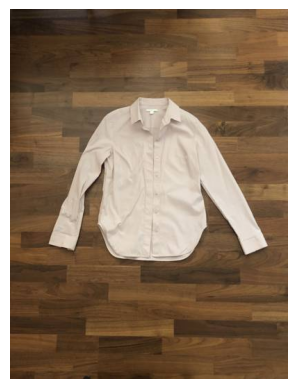

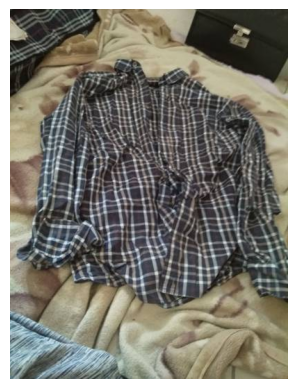

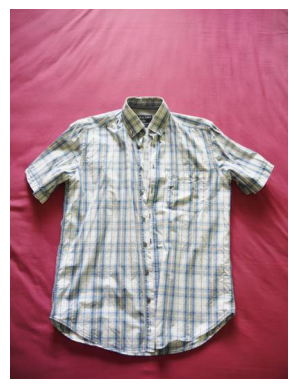

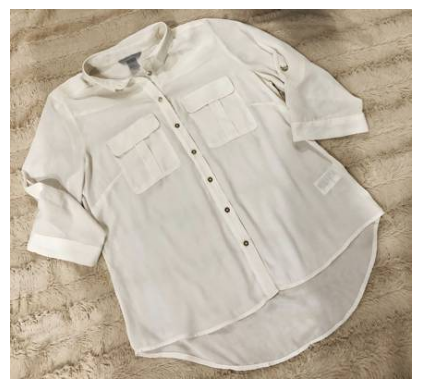

In [54]:
for path in image_path:
    display_jpg_image('dataset/' + path)